In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod

In [2]:
dataset = MNIST()
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN()

train_cnn(cnn, dataset, iterations=2, lr=0.001, device='cpu', save_fn='mnist-cnn', load_path="./models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


d:\david\miniconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [5]:
# Train or load autoencoder
cae = CAE()

train_ae(cae, dataset, iterations=2, save_fn="mnist-cae", load_path="./models/saved_models/mnist-cae.h5")

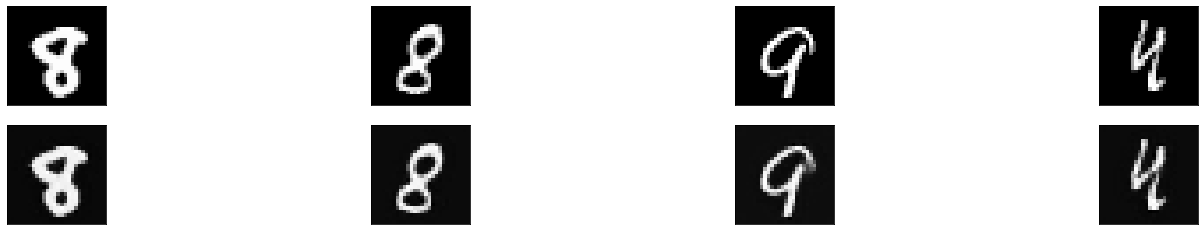

In [6]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [7]:
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=4, n_searches=1)

In [8]:
# obtain one sample
image, _ = dataset.get_sample()

CEM.fista(image)

search iteration: 1
current loss: 9.999943733215332
search iteration: 2
current loss: 9.999943733215332
search iteration: 3
current loss: 9.999943733215332
search iteration: 4
current loss: 9.999943733215332


In [9]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files/Graphviz/bin'

from torchviz import make_dot
make_dot(CEM.loss).view()

'Digraph.gv.pdf'